<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/replication_of_rl_lateral_controller_for_autonomous_vehicles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [1]:
!pip install pygame
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 2.1 MB/s eta 0:00:00


Testing

In [2]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np


from IPython.display import Image, display
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
%matplotlib inline

Environment Definition

In [3]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

In [4]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs,a):
    self.obs = obs
    self.a = a

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
    # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
    ego_vehicle = env.unwrapped.vehicle
    lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]
    if lead_vehicle:
      gap = lead_vehicle.position[0] - ego_vehicle.position[0]
      delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
      self.longitudinal_lead_state = {"x": gap, "vx": delta_velocity}

    else:
      self.longitudinal_lead_state = {"x": 10, "vx": 0}

    return self.longitudinal_lead_state

  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2+1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1])

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  #Acceleration to Steering angle
  def steering_angle(self, agent_action,L=1):
    """
    Steering Angle: theta = atan(a_yaw/v^2)
    a_yaw = lateral acceleration (agent_action)
    v = vehicle speed (vx)
    """
    self.angle = math.atan(L*agent_action/self.ego_state_idm()['vx']**2)

    return self.angle

Agent Defintion

In [5]:
class Agent(nn.Module):
  """
  s = (x, y, vx, vy, thetha, lane_width, lane_id, self_curvature, longitudinal_acceleration) ∈ S

  Lateral Agent State:
  x = vehicle x position
  y = vehicle y position
  vx = vehicle speed (longitudinal)
  thetha = yaw angle (heading)
  lane_width = width of the lane
  lane_id = target lane id
  self_curvature = road curvature at the vehicle's position
  longitudinal_acceleration = vehicle longitudinal acceleration
  """
  def __init__(self, state_dim):
    super(Agent, self).__init__()
    self.state_dim = state_dim
    # Define Network A & C
    self.networkA = nn.Sequential(
        nn.Linear(self.state_dim, 100),
        nn.Linear(100, 1),
        nn.Softplus()
    )
    self.networkC = nn.Sequential(
        nn.Linear(self.state_dim + 1, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
    )

    # Define Network B
    self.networkB1 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB2 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB3 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )

  def forward(self, state, a, terminal):
    """
    Q(s,a) = A(s)*(B(s)-a)^2 + C(s)
    """
    if isinstance(state, dict):
      state_tensor = torch.tensor(
          [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32
      ).unsqueeze(0)
    else:
        self.state = state
    # Use a directly if it's already a tensor
    self.a = a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.float32)
    self.terminal_condition = terminal if isinstance(terminal, torch.Tensor) else torch.tensor([[terminal]], dtype=torch.float32)

    # Output of the Networks
    self.A = -self.networkA(self.state)
    self.C = self.networkC(torch.concat((self.state, self.terminal_condition), dim=1))
    self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))

    # Q-function Approximation
    q_value = self.A * ((self.B - self.a) ** 2) + self.C

    return q_value

  def action(self, state):
      # Convert it to a tensor
      if isinstance(state, dict):
          state_tensor = torch.tensor(
              [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
              dtype=torch.float32
          ).unsqueeze(0)
      else:
          state_tensor = state
      self.state = state_tensor
      self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))
      return self.B

Experience Buffer

In [6]:
# Buffer Class
class Experience_Buffer():
  """
  Define Experience Buffer
  """
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    # Define Buffer as Deque with Limit of Default Size buffer_size elements
    self.buffer = deque(maxlen=self.buffer_size)

  def add(self, state, action, reward, next_state, terminal_condition):
    # Experience is the state transition tensor/vector
    state_tensor = torch.tensor(
        [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
        dtype=torch.float32
    ).unsqueeze(0)
    next_state_tensor = torch.tensor(
        [next_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
        dtype=torch.float32
    ).unsqueeze(0)
    action_tensor = torch.tensor([[action]], dtype=torch.float32)
    reward_tensor = torch.tensor([[reward]], dtype=torch.float32)
    terminal_tensor = torch.tensor([[terminal_condition]], dtype=torch.float32)

    self.transition = torch.concat((state_tensor, action_tensor, reward_tensor,
                                    next_state_tensor, terminal_tensor), dim=1)
    self.buffer.append(self.transition)

  def sample_experience(self, batch_size):
    # Randomly sample Experience from buffer
    batch = random.sample(self.buffer, batch_size)
    return batch

  def size(self):
    # Return the current number of elements in the buffer.
    return len(self.buffer)


Lateral Controller (Gap Checker)

In [7]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        # The candidate lane is chosen based on the largest front gap.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Longitudinal Controller

In [8]:
class IDM():
    ''' Intelligent Driving Model for Longitudinal Control

    Control parameters:
      a: maximum acceleration
      b: comfortable deceleration
      delta: acceleration exponent
      T: safe time headway

    Parameters:
      s0: minimum gap
      v0: desired speed

      a (Maximum Acceleration): How fast the vehicle can speed up (m/s²).
      b (Comfortable Deceleration): How smoothly the vehicle slows down (m/s²).
      δ (Acceleration Exponent): The non-linearity factor in acceleration.
      T (Safe Time Headway): The desired minimum following time gap (s).

    Input variables:
      s: current gap
      v: current vehicle speed
      delta_v: relative speed (difference between the vehicle's speed and the leading vehicle's speed)
    '''

    def __init__(self, desired_parameters, control_parameters):
        # Unpack initial parameters: [s0, v0]
        self.s0, self.v0 = desired_parameters
        # Unpack control parameters: [a, b, delta, T]
        self.a, self.b, self.delta, self.T = control_parameters

    def longitudinal_controller(self, input_variables):
        # Unpack input variables: [s, v, delta_v]
        s, v, delta_v = input_variables

        # Small epsilon to account for very small gaps and avoid division by zero
        epsilon = 1e-6

        # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
        desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

        # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
        acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

        return acceleration

Initialize Environment

In [9]:
# Initialize Environment
obs, _ = env.reset()

# Initialize Environment Manager and Reward
state_manager = ENV(obs,obs[0][2])

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

# Initial Longitundinal Positions
ego_position_idm = ego_state_idm['x']
lead_position_idm = lead_state['x']

# Initial Velocities (using vx for longitudinal control)
ego_velocity_idm = ego_state_idm['vx']
lead_velocity_idm = lead_state['vx']

Training Loop

Cartpole Test

Episode   1/500 │ Steps: 21 │ Return:  21 │ ε=0.998
Episode   2/500 │ Steps: 29 │ Return:  29 │ ε=0.995


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode   3/500 │ Steps: 16 │ Return:  16 │ ε=0.993
Episode   4/500 │ Steps: 18 │ Return:  18 │ ε=0.992
Episode   5/500 │ Steps: 46 │ Return:  46 │ ε=0.987
Episode   6/500 │ Steps: 14 │ Return:  14 │ ε=0.986
Episode   7/500 │ Steps: 18 │ Return:  18 │ ε=0.984
Episode   8/500 │ Steps: 46 │ Return:  46 │ ε=0.979
Episode   9/500 │ Steps: 42 │ Return:  42 │ ε=0.975
Episode  10/500 │ Steps: 26 │ Return:  26 │ ε=0.972
Episode  11/500 │ Steps: 32 │ Return:  32 │ ε=0.969
Episode  12/500 │ Steps: 21 │ Return:  21 │ ε=0.967
Episode  13/500 │ Steps: 17 │ Return:  17 │ ε=0.965
Episode  14/500 │ Steps: 15 │ Return:  15 │ ε=0.964
Episode  15/500 │ Steps: 20 │ Return:  20 │ ε=0.962
Episode  16/500 │ Steps: 13 │ Return:  13 │ ε=0.961
Episode  17/500 │ Steps: 12 │ Return:  12 │ ε=0.959
Episode  18/500 │ Steps: 19 │ Return:  19 │ ε=0.958
Episode  19/500 │ Steps: 16 │ Return:  16 │ ε=0.956
Episode  20/500 │ Steps: 17 │ Return:  17 │ ε=0.954
Episode  21/500 │ Steps: 33 │ Return:  33 │ ε=0.951
Episode  22/

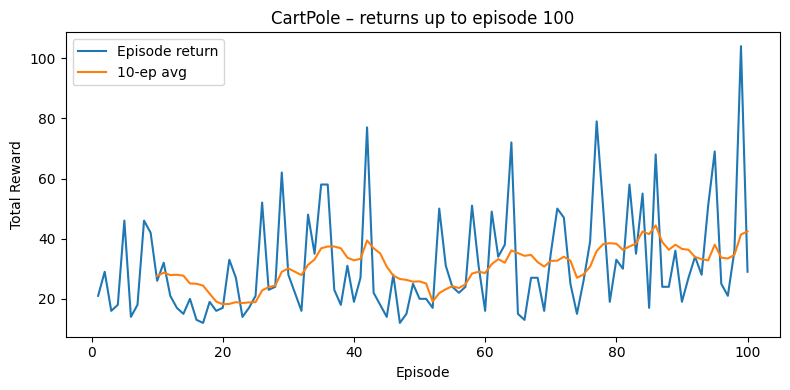

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 101/500 │ Steps: 48 │ Return:  48 │ ε=0.682
Episode 102/500 │ Steps: 48 │ Return:  48 │ ε=0.677
Episode 103/500 │ Steps: 13 │ Return:  13 │ ε=0.676
Episode 104/500 │ Steps: 77 │ Return:  77 │ ε=0.668
Episode 105/500 │ Steps: 17 │ Return:  17 │ ε=0.667
Episode 106/500 │ Steps: 42 │ Return:  42 │ ε=0.663
Episode 107/500 │ Steps: 12 │ Return:  12 │ ε=0.661
Episode 108/500 │ Steps: 31 │ Return:  31 │ ε=0.658
Episode 109/500 │ Steps: 26 │ Return:  26 │ ε=0.656
Episode 110/500 │ Steps: 11 │ Return:  11 │ ε=0.655
Episode 111/500 │ Steps: 12 │ Return:  12 │ ε=0.653
Episode 112/500 │ Steps:  9 │ Return:   9 │ ε=0.652
Episode 113/500 │ Steps: 11 │ Return:  11 │ ε=0.651
Episode 114/500 │ Steps: 27 │ Return:  27 │ ε=0.649
Episode 115/500 │ Steps:  8 │ Return:   8 │ ε=0.648
Episode 116/500 │ Steps:  8 │ Return:   8 │ ε=0.647
Episode 117/500 │ Steps: 13 │ Return:  13 │ ε=0.646
Episode 118/500 │ Steps: 34 │ Return:  34 │ ε=0.642
Episode 119/500 │ Steps:  9 │ Return:   9 │ ε=0.641
Episode 120/

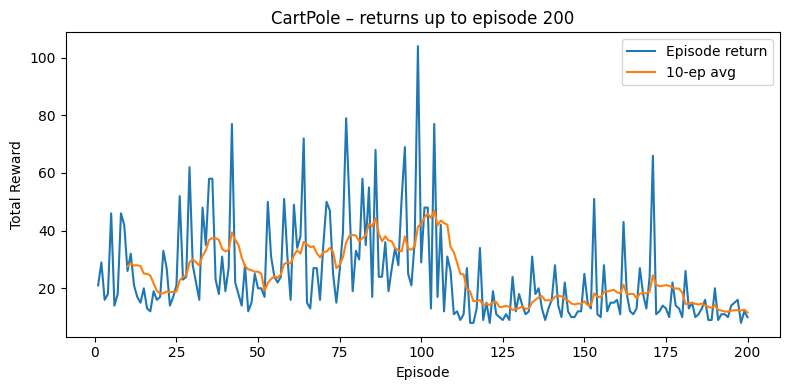

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 201/500 │ Steps: 56 │ Return:  56 │ ε=0.508
Episode 202/500 │ Steps: 10 │ Return:  10 │ ε=0.507
Episode 203/500 │ Steps: 17 │ Return:  17 │ ε=0.505
Episode 204/500 │ Steps:  9 │ Return:   9 │ ε=0.505
Episode 205/500 │ Steps: 26 │ Return:  26 │ ε=0.502
Episode 206/500 │ Steps: 19 │ Return:  19 │ ε=0.500
Episode 207/500 │ Steps: 16 │ Return:  16 │ ε=0.498
Episode 208/500 │ Steps: 44 │ Return:  44 │ ε=0.494
Episode 209/500 │ Steps: 13 │ Return:  13 │ ε=0.493
Episode 210/500 │ Steps: 23 │ Return:  23 │ ε=0.490
Episode 211/500 │ Steps: 12 │ Return:  12 │ ε=0.489
Episode 212/500 │ Steps: 23 │ Return:  23 │ ε=0.487
Episode 213/500 │ Steps: 15 │ Return:  15 │ ε=0.485
Episode 214/500 │ Steps:  9 │ Return:   9 │ ε=0.485
Episode 215/500 │ Steps: 17 │ Return:  17 │ ε=0.483
Episode 216/500 │ Steps: 11 │ Return:  11 │ ε=0.482
Episode 217/500 │ Steps: 27 │ Return:  27 │ ε=0.479
Episode 218/500 │ Steps:  9 │ Return:   9 │ ε=0.478
Episode 219/500 │ Steps: 10 │ Return:  10 │ ε=0.477
Episode 220/

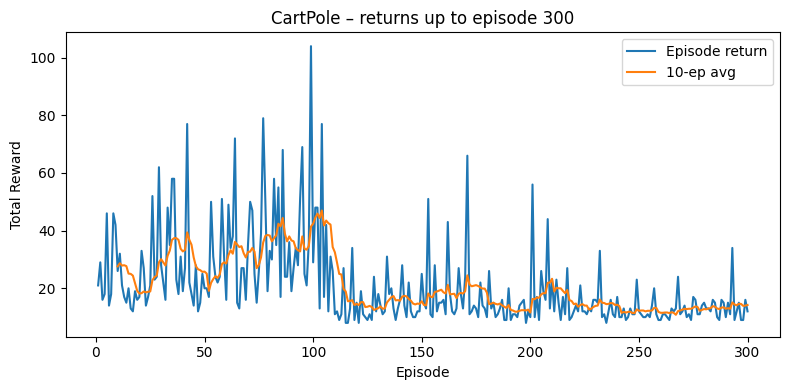

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 301/500 │ Steps: 13 │ Return:  13 │ ε=0.370
Episode 302/500 │ Steps: 17 │ Return:  17 │ ε=0.369
Episode 303/500 │ Steps: 13 │ Return:  13 │ ε=0.367
Episode 304/500 │ Steps: 10 │ Return:  10 │ ε=0.366
Episode 305/500 │ Steps: 10 │ Return:  10 │ ε=0.365
Episode 306/500 │ Steps: 10 │ Return:  10 │ ε=0.364
Episode 307/500 │ Steps: 15 │ Return:  15 │ ε=0.363
Episode 308/500 │ Steps: 12 │ Return:  12 │ ε=0.362
Episode 309/500 │ Steps: 12 │ Return:  12 │ ε=0.360
Episode 310/500 │ Steps: 10 │ Return:  10 │ ε=0.359
Episode 311/500 │ Steps: 10 │ Return:  10 │ ε=0.358
Episode 312/500 │ Steps: 13 │ Return:  13 │ ε=0.357
Episode 313/500 │ Steps: 14 │ Return:  14 │ ε=0.356
Episode 314/500 │ Steps: 10 │ Return:  10 │ ε=0.355
Episode 315/500 │ Steps: 16 │ Return:  16 │ ε=0.353
Episode 316/500 │ Steps:  9 │ Return:   9 │ ε=0.352
Episode 317/500 │ Steps: 12 │ Return:  12 │ ε=0.351
Episode 318/500 │ Steps: 14 │ Return:  14 │ ε=0.350
Episode 319/500 │ Steps: 15 │ Return:  15 │ ε=0.348
Episode 320/

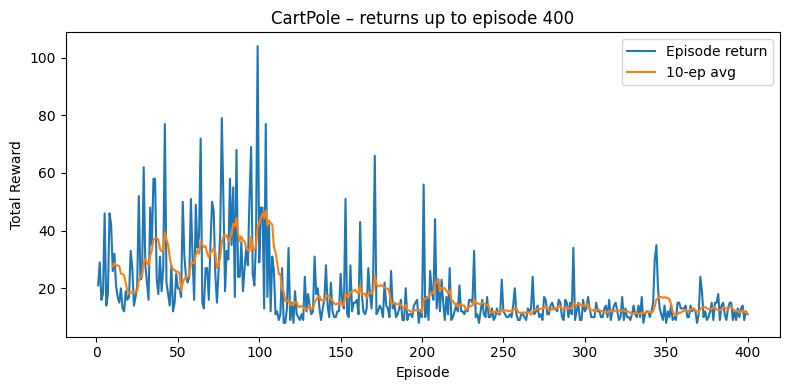

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 401/500 │ Steps: 10 │ Return:  10 │ ε=0.245
Episode 402/500 │ Steps: 14 │ Return:  14 │ ε=0.243
Episode 403/500 │ Steps: 15 │ Return:  15 │ ε=0.242
Episode 404/500 │ Steps: 12 │ Return:  12 │ ε=0.241
Episode 405/500 │ Steps:  9 │ Return:   9 │ ε=0.240
Episode 406/500 │ Steps: 17 │ Return:  17 │ ε=0.238
Episode 407/500 │ Steps: 11 │ Return:  11 │ ε=0.237
Episode 408/500 │ Steps: 10 │ Return:  10 │ ε=0.236
Episode 409/500 │ Steps: 11 │ Return:  11 │ ε=0.235
Episode 410/500 │ Steps: 11 │ Return:  11 │ ε=0.234
Episode 411/500 │ Steps: 12 │ Return:  12 │ ε=0.232
Episode 412/500 │ Steps: 10 │ Return:  10 │ ε=0.231
Episode 413/500 │ Steps: 13 │ Return:  13 │ ε=0.230
Episode 414/500 │ Steps: 12 │ Return:  12 │ ε=0.229
Episode 415/500 │ Steps: 11 │ Return:  11 │ ε=0.228
Episode 416/500 │ Steps: 10 │ Return:  10 │ ε=0.227
Episode 417/500 │ Steps: 10 │ Return:  10 │ ε=0.226
Episode 418/500 │ Steps: 11 │ Return:  11 │ ε=0.225
Episode 419/500 │ Steps: 11 │ Return:  11 │ ε=0.224
Episode 420/

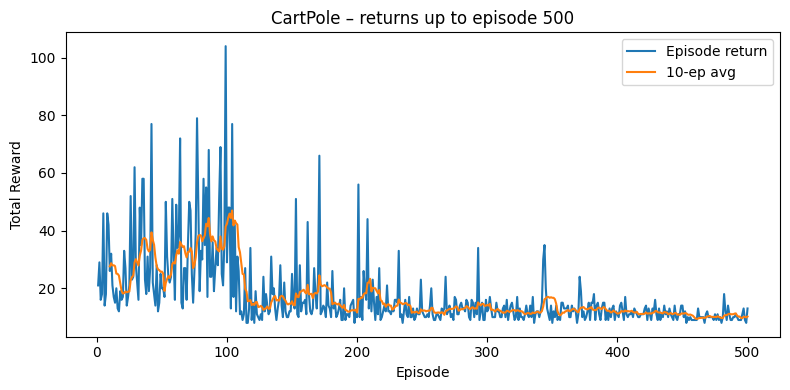

In [22]:
################################################################################
#                       CARTPOLE‑v1  TRAINING  LOOP                             #
################################################################################
#
#  – Re‑uses your   Agent(state_dim)   architecture
#  – Discrete actions are taken as    action = int(B(s) > 0)
#  – Standard DQN with replay + target network
#  – Periodic reward plots and an inline animation of the agent’s behaviour
#
################################################################################
import gymnasium
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import matplotlib.animation as animation

# ────────────────────────────────  ENV  ───────────────────────────────────────
cart_env   = gymnasium.make("CartPole-v1", render_mode=None)
state_dim  = cart_env.observation_space.shape[0]            # 4
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────  HYPERS  ───────────────────────────────────────
gamma                 = 0.99
batch_size            = 32
target_update_every   = 100          # env steps
num_episodes          = 500
max_steps_per_episode = 500
eps_start, eps_end    = 1.0, 0.05
eps_decay_per_step    = 1e-4           # linear decay
lr                    = 1e-2

plot_every   = 100                     # draw reward plot every N episodes
render_every = 100                     # show animation every N episodes

episode_returns = []
global_step     = 0
epsilon         = eps_start

# ─────────────────────────────  NETWORKS  ────────────────────────────────────
cart_policy_net = Agent(state_dim).to(device)
cart_target_net = Agent(state_dim).to(device)

optimizer = optim.Adam(cart_policy_net.parameters(), lr=lr)
loss_fn   = nn.MSELoss()

# ────────────────────────────  REPLAY BUFFER  ────────────────────────────────
class ReplayBuf:
    def __init__(self, capacity=50_000):
        self.buf = deque(maxlen=capacity)
    def add(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    def sample(self, batch):
        batch = random.sample(self.buf, batch)
        s, a, r, s2, d = zip(*batch)
        return (torch.stack(s).to(device),
                torch.tensor(a, dtype=torch.float32, device=device).unsqueeze(1),
                torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
                torch.stack(s2).to(device),
                torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1))
    def __len__(self):
        return len(self.buf)

replay = ReplayBuf()

# ────────────────────────────  RENDER HELPER  ────────────────────────────────
def play_episode(policy_net, device, max_steps=500):
    """Runs one episode with greedy policy and returns list of RGB frames."""
    vis_env = gymnasium.make("CartPole-v1", render_mode="rgb_array")
    obs, _  = vis_env.reset()
    frames  = []
    for _ in range(max_steps):
        state_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            b_val = policy_net.action(state_t).item()
            act   = int(b_val > 0.0)
        obs, _, term, trunc, _ = vis_env.step(act)
        frames.append(vis_env.render())
        if term or trunc:
            break
    vis_env.close()
    return frames

# ─────────────────────────── TRAINING LOOP  ──────────────────────────────────
for ep in range(num_episodes):
    obs, _  = cart_env.reset()
    state   = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    done    = False
    steps   = 0
    ep_ret  = 0.0

    while not done and steps < max_steps_per_episode:
        steps       += 1
        global_step += 1

        # ε‑greedy action choice
        if random.random() < epsilon:
            action = cart_env.action_space.sample()
        else:
            with torch.no_grad():
                b_val  = cart_policy_net.action(state).item()
                action = int(b_val > 0.0)

        # Environment step
        obs2, reward, terminated, truncated, _ = cart_env.step(action)
        done        = terminated or truncated
        ep_ret     += reward
        next_state  = torch.tensor(obs2, dtype=torch.float32).unsqueeze(0).to(device)

        # Save transition
        replay.add(state.squeeze(0), action, reward, next_state.squeeze(0), float(done))
        state = next_state

        # Learning step
        if len(replay) >= batch_size:
            s_b, a_b, r_b, s2_b, d_b = replay.sample(batch_size)

            q_curr = cart_policy_net(s_b, a_b, d_b)  # Q(s,a)

            with torch.no_grad():
                b_next   = cart_policy_net.action(s2_b)
                a_next   = (b_next > 0).float().unsqueeze(1)
                q_next   = cart_target_net(s2_b, a_next, d_b)
                q_target = r_b + gamma * q_next * (1.0 - d_b)

            loss = loss_fn(q_curr, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Target‑net sync & ε‑decay
        if global_step % target_update_every == 0:
            cart_target_net.load_state_dict(cart_policy_net.state_dict())
        epsilon = max(eps_end, epsilon - eps_decay_per_step)

    episode_returns.append(ep_ret)

    # Logging
    print(f"Episode {ep+1:3}/{num_episodes} │ Steps:{steps:3} "
          f"│ Return:{ep_ret:4.0f} │ ε={epsilon:0.3f}")

    # ── Reward Plot ──────────────────────────────────────────────────────────
    if (ep + 1) % plot_every == 0:
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(episode_returns)+1), episode_returns,
                 label="Episode return")
        if len(episode_returns) >= 10:
            ma = (torch.tensor(episode_returns)
                  .float()
                  .unfold(0, 10, 1)
                  .mean(1))
            plt.plot(range(10, len(episode_returns)+1),
                     ma, label="10‑ep avg")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title(f"CartPole – returns up to episode {ep+1}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ── Inline Animation ─────────────────────────────────────────────────────
    if (ep + 1) % render_every == 0:
        frames = play_episode(cart_policy_net, device)
        fig, ax = plt.subplots()
        img = ax.imshow(frames[0]); ax.axis("off")

        def animate(i):
            img.set_data(frames[i])
            return (img,)

        ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                                      interval=30, blit=True)
        plt.close(fig)                # don’t show the static first frame
        display(HTML(ani.to_jshtml()))

cart_env.close()
################################################################################
#                         END  CARTPOLE LOOP                                    #
################################################################################


Mountain Car

In [54]:
################################################################################
#                    MOUNTAIN CAR CONTINUOUS  TRAINING  LOOP                    #
################################################################################
#
# – Re‑uses your Agent(state_dim) architecture (scalar output B(s))
# – Continuous 1‑D action:  a = tanh(B(s)) + Gaussian noise  ∈ [‑1,1]
# – Noise standard deviation decays linearly over training steps
# – Q‑learning with replay + target network
# – Reward, loss plot, and inline animation appear together every plot_every episodes
#
################################################################################
import gymnasium
from collections import deque
import random, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import matplotlib.animation as animation

# ────────────────────────────────  ENV  ───────────────────────────────────────
env               = gymnasium.make("MountainCarContinuous-v0", render_mode=None)
state_dim         = env.observation_space.shape[0]      # 2  (pos, vel)
act_low, act_high = env.action_space.low[0], env.action_space.high[0]  # -1, 1
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────  HYPERS  ───────────────────────────────────────
gamma                 = 0.99
batch_size            = 500
target_update_every   = 50            # env steps
num_episodes          = 200
max_steps_per_episode = 999

noise_start           = 0.1           # initial exploration noise std
noise_end             = 0.01          # final exploration noise std

total_steps           = num_episodes * max_steps_per_episode
noise_decay           = (noise_start - noise_end) / total_steps

noise_std             = noise_start  # will be decayed each step

lr                    = 1e-3

plot_every            = 10            # plot + render cadence

episode_returns = []
loss_history    = []                  # track loss over updates
global_step     = 0

# ─────────────────────────────  NETWORKS  ────────────────────────────────────
policy_net = Agent(state_dim).to(device)
target_net = Agent(state_dim).to(device)
optimizer  = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn    = nn.MSELoss()

# ────────────────────────────  REPLAY BUFFER  ────────────────────────────────
class ReplayBuf:
    def __init__(self, capacity=100_000):
        self.buf = deque(maxlen=capacity)
    def add(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    def sample(self, n):
        batch = random.sample(self.buf, n)
        s, a, r, s2, d = zip(*batch)
        return (torch.stack(s).to(device),
                torch.tensor(a, dtype=torch.float32, device=device).unsqueeze(1),
                torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
                torch.stack(s2).to(device),
                torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1))
    def __len__(self):
        return len(self.buf)

replay = ReplayBuf()

# ────────────────────────────  RENDER HELPER  ────────────────────────────────
def play_episode(net, device, max_steps=999):
    """Runs one greedy episode and returns a list of RGB frames."""
    vis = gymnasium.make("MountainCarContinuous-v0", render_mode="rgb_array")
    obs, _ = vis.reset()
    frames = []
    for _ in range(max_steps):
        s = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            b = net.action(s).item()
            a = float(np.tanh(b))  # no noise in evaluation
        obs, _, term, trunc, _ = vis.step([a])
        frames.append(vis.render())
        if term or trunc:
            break
    vis.close()
    return frames

# ─────────────────────────── TRAINING LOOP  ──────────────────────────────────
for ep in range(1, num_episodes+1):
    obs, _ = env.reset()
    state  = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    done   = False
    steps  = 0
    ep_ret = 0.0

    while not done and steps < max_steps_per_episode:
        steps       += 1
        global_step += 1

        # ——— Continuous action with Gaussian noise ————————————————
        with torch.no_grad():
            b_val      = policy_net.action(state).item()
        raw_action = (b_val)
        noise      = np.random.normal(0, noise_std)
        action_val = float(np.clip(raw_action + noise, act_low, act_high))

        # decay noise
        noise_std  = max(noise_end, noise_std - noise_decay)

        # ——— Environment step ——————————————————————————————————————
        obs2, reward, terminated, truncated, _ = env.step([action_val])
        done       = terminated or truncated
        ep_ret    += reward
        next_state = torch.tensor(obs2, dtype=torch.float32).unsqueeze(0).to(device)

        # ——— Store transition ——————————————————————————————————————
        replay.add(state.squeeze(0), action_val, reward,
                   next_state.squeeze(0), float(done))
        state = next_state

        # ——— Learning step ——————————————————————————————————————
        if len(replay) >= batch_size:
            s_b, a_b, r_b, s2_b, d_b = replay.sample(batch_size)

            q_curr = policy_net(s_b, a_b, d_b)
            with torch.no_grad():
                b_next   = policy_net.action(s2_b)
                a_next   = (b_next)
                q_next   = target_net(s2_b, a_next, d_b)
                q_target = r_b + gamma * q_next * (1 - d_b)

            loss = loss_fn(q_curr, q_target)
            loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ——— Target‑net sync ——————————————————————————————————————
        if global_step % target_update_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

    episode_returns.append(ep_ret)

    print(f"Ep {ep:3}/{num_episodes} │ Steps:{steps:3} "
          f"│ Return:{ep_ret:7.2f}")

    # ── Reward & Loss plot + inline animation ────────────────────────────────
    if ep % plot_every == 0:
        # 1) reward curve
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(episode_returns)+1), episode_returns, label="Return")
        if len(episode_returns) >= 10:
            ma = torch.tensor(episode_returns, dtype=torch.float32).unfold(0,10,1).mean(1)
            plt.plot(range(10, len(episode_returns)+1), ma, label="10‑ep avg")
        plt.xlabel("Episode"); plt.ylabel("Total reward")
        plt.title(f"Returns up to ep {ep}")
        plt.legend(); plt.tight_layout(); plt.show()

        # 2) loss curve
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(loss_history)+1), loss_history, label="Loss")
        plt.xlabel("Update #"); plt.ylabel("MSE Loss")
        plt.title(f"Loss up to ep {ep}")
        plt.tight_layout(); plt.show()

        # 3) inline animation
        frames = play_episode(policy_net, device)
        fig, ax = plt.subplots()
        img = ax.imshow(frames[0]); ax.axis("off")
        def animate(i):
            img.set_data(frames[i])
            return (img,)
        ani = animation.FuncAnimation(fig, animate,
                                      frames=len(frames),
                                      interval=30, blit=True)
        plt.close(fig)
        display(HTML(ani.to_jshtml()))

env.close()
################################################################################
#                    END  MOUNTAIN CAR CONTINUOUS LOOP                          #
################################################################################


Ep   1/200 │ Steps:999 │ Return:  -0.98


KeyboardInterrupt: 

Always Active (Option 1)

In [ ]:
################################################################################
"""Initialization"""
################################################################################
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Set initial Input variables using the gap, current velocity, and relative lead velocity
input_variables = [lead_position_idm, ego_velocity_idm, lead_velocity_idm]

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Agent Initialization
total_steps_taken = 0
lr = 0.01
gamma = 0.9
buffer_size = 5000
num_episodes = 100
batch_size = 100
timesteps = 40000
update_target_frequency = 50
threshold = 30
plot_frequency = 50

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

# Initialize Buffer
buffer = Experience_Buffer(buffer_size)

# Setup Lateral Control Agent
target_network = Agent(state_dim).to(device)
policy_network = Agent(state_dim).to(device)

# Initialize target network
target_network.load_state_dict(policy_network.state_dict())

# Loss and Criterion Initialization
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr)
policy_loss_fn = nn.MSELoss()

# Tracking loss values and timestep rewards over training steps
loss_history = []
timestep_rewards = []

################################################################################
"""Training & Testing Loop"""
################################################################################
for episodes in range(num_episodes):
    # Reset environment and state manager
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # Initial state information
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    on_road_check = True
    collision_check = False

    # Agent activation flag and target lane storage
    activated_target_lane = None

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    steps = 0
    terminal = 0

    # For stepwise plotting, record agent actions per timestep
    episode_actions = []

    # Main loop for each episode
    while terminal == 0 and not collision_check:
        steps += 1

        # Recompute gap
        gap = lead_state['x']

        ########################################################################
        """Action Preparation"""
        ########################################################################
        gap_control = Gap_Controller(obs, threshold)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        with torch.no_grad():
            agent_action = policy_network.action(agent_state).item()

        # Store prior state for buffer
        old_state = agent_state
        obs_old = obs

        # IDM Longitudinal Control
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Record the action for later stepwise plotting (e.g., steering angle per timestep)
        episode_actions.append(agent_action)

        # Transform agent action (acceleration prediction) to steering angle
        lateral_control = state_manager.steering_angle(agent_action, L)

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        ########################################################################
        """Data Collection"""
        ########################################################################
        obs, reward, done, truncated, info = env.step(action)

        # Check for off-road or collision events
        on_road_check = env.unwrapped.vehicle.on_road
        collision_check = info['crashed']

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)

        # Compute reward based on the new state (reward_per_episode is a list; we use index 0)
        reward_per_episode = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_per_episode[0]

        # Append the reward from the current timestep (no accumulation)
        timestep_rewards.append(reward_per_episode)

        # Terminal Condition Check
        if not on_road_check or steps == timesteps:
            terminal = 1

        ########################################################################
        """Update IDM Controller Inputs for next step"""
        ########################################################################
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        # Update experience buffer
        buffer.add(old_state, agent_action, reward, agent_state, terminal)

        ########################################################################
        """Periodic Plotting for Environment Render"""
        ########################################################################
        if episodes % plot_frequency == 0:
            plt.imshow(env.render())
            plt.title(f"Environment Render at Episode {episodes}, Step {steps}")
            plt.axis('off')
            plt.show()

        ########################################################################
        """Q-Learning Update"""
        ########################################################################
        if buffer.size() >= batch_size:

            # Sample random experience for training
            rand_experience = buffer.sample_experience(batch_size=batch_size)
            transitions = torch.cat([t for t in rand_experience if isinstance(t, torch.Tensor)], dim=0).to(device)

            states, actions, rewards, next_states, terminals = torch.split(
                transitions, [state_dim, 1, 1, state_dim, 1], dim=1)
            current_q_values = policy_network(states, actions, terminals)

            with torch.no_grad():
                target_network.eval()
                next_state = torch.cat((next_states, terminals), dim=1)
                max_next_q_values = target_network.networkC(next_state)

            target_q_values = rewards + gamma * max_next_q_values * (1.0 - terminals)
            loss = policy_loss_fn(current_q_values, target_q_values)
            loss_history.append(loss.item())

            policy_optimizer.zero_grad()
            loss.backward()
            policy_optimizer.step()

            total_steps_taken += 1

    ############################################################################
    """Update Target Policy Network"""
    ############################################################################
    if episodes % update_target_frequency == 0:
        target_network.load_state_dict(policy_network.state_dict())
        print(f"**** Target network updated at episode {episodes} ****")

    print(f"Episode {episodes} finished after {steps} steps.")

    ############################################################################
    """Periodic Plotting of Reward and Loss after DQN Update (every x episodes)"""
    ############################################################################
    if episodes % plot_frequency == 0 and episodes > 0 and buffer.size() >= batch_size:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(episode_actions)), episode_actions, label="Steering Action (a_yaw)")
        plt.xlabel("Time Step")
        plt.ylabel(f"Agent Action per Step (Episode {episodes})")
        plt.legend()
        plt.title("Agent Action per Step")
        plt.tight_layout()
        plt.show()

        # Plot Reward per Timestep
        plt.figure(figsize=(12, 5))
        plt.plot(range(len(timestep_rewards)), timestep_rewards, label=['R_Total','R_acce','R_rate','R_time'])
        plt.xlabel("Timestep")
        plt.ylabel("Reward")
        plt.title("Reward per Timestep (Accumulated over Episodes)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot Loss over Training Updates
        plt.figure()
        plt.plot(loss_history)
        plt.xlabel("Q-Learning Update")
        plt.ylabel("Loss")
        plt.title("Loss over Training Updates")
        plt.show()


Inactive Agent Until Lane (Option 2)

In [ ]:
################################################################################
"""Initialization"""
################################################################################
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [40, 10.0]       # s0, v0

# Set initial Input variables using the gap, current velocity, and relative lead velocity
input_variables = [lead_position_idm, ego_velocity_idm, lead_velocity_idm]

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Agent Initialization
total_steps_taken = 0
lr = 0.01
gamma = 0.9
buffer_size = 1000
num_episodes = 10000
batch_size = 500
timesteps = 40000
update_target_frequency = 10
# epsilon_decay_rate = 10000
threshold = 30
plot_frequency = 10
threshold = 30
thetha_threshold = 0.1

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

# Initialize Buffer
buffer = Experience_Buffer(buffer_size)

# Setup Lateral Control Agent
target_network = Agent(state_dim).to(device)
policy_network = Agent(state_dim).to(device)

# Initialize target network
target_network.load_state_dict(policy_network.state_dict())

# Loss and Criterion Initialization
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr)
policy_loss_fn = nn.MSELoss()

# Tracking loss values and storing per-timestep rewards for plotting.
loss_history = []
# We remove the per-episode accumulation.
# episode_rewards = []
timestep_rewards = []  # New list: store each timestep's reward directly.

################################################################################
"""Training & Testing Loop"""
################################################################################
for episodes in range(num_episodes):
    # Reset environment and state manager
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # Initial state information
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    on_road_check = True
    collision_check = False

    # Agent activation flag and target lane storage
    activated_target_lane = None

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    steps = 0
    terminal = 0
    # Removed cumulative episode reward accumulation.
    # current_episode_reward = 0
    # episode_acce_reward = 0
    # episode_rate_reward = 0
    # episode_time_reward = 0
    counter = 0
    # epsilon = 0.1

    # For stepwise plotting, record agent actions per timestep
    episode_actions = []

    # Main loop for each episode
    while steps < timesteps and counter < 1:
        steps += 1
        # Epsilon decay based on total_steps_taken
        # epsilon = max(0.05, 0.1 - (0.1 - 0.05) * (total_steps_taken / epsilon_decay_rate))

        # Recompute gap
        gap = lead_state['x']

        ########################################################################
        """Action Preparation"""
        ########################################################################
        gap_control = Gap_Controller(obs, threshold)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        with torch.no_grad():
            # Agent Remains Inactive Unless Heading and Gap Meet a Requirement
            if (gap < threshold and target_id != env.unwrapped.vehicle.lane_index[2]) or abs(agent_state['thetha']) > thetha_threshold:
                agent_action = policy_network.action(agent_state).item()
            else:
                agent_action = 0

        # Store prior state for buffer
        old_state = agent_state
        obs_old = obs

        # IDM Longitudinal Control
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Record the action for later stepwise plotting (e.g., steering angle per timestep)
        episode_actions.append(agent_action)

        # Transform agent action (acceleration prediction) to steering angle
        steering_angle = state_manager.steering_angle(agent_action, L)
        lateral_control = steering_angle

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        ########################################################################
        """Data Collection"""
        ########################################################################
        obs, reward, done, truncated, info = env.step(action)

        # Check for off-road or collision events
        on_road_check = env.unwrapped.vehicle.on_road
        collision_check = info['crashed']

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)
        # Compute reward based on the new state
        reward_per_episode = state_manager.reward_function(obs_old, obs, target_id)
        # Grab the reward (the first element of the returned list)
        reward = reward_per_episode[0]

        # Instead of adding up rewards per episode, simply append the reward from this timestep.
        timestep_rewards.append(reward)

        # Removed cumulative sums:
        # current_episode_reward += reward
        # episode_acce_reward += reward_per_episode[1]
        # episode_rate_reward += reward_per_episode[2]
        # episode_time_reward += reward_per_episode[3]

        ########################################################################
        """Update IDM Controller Inputs for next step"""
        ########################################################################
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        ########################################################################
        """Terminal Condition Check"""
        ########################################################################
        # Update error counter
        if not on_road_check or collision_check:
            counter += 1
            terminal = 1

        # Terminal condition check: if steps reaches timesteps, mark terminal.
        if steps == timesteps:
            terminal = 1
        else:
            terminal = 0

        # Update experience buffer
        buffer.add
